## Predicting combinatorial drug perturbations

In this tutorial, we train CPA on combo-sciplex dataset. This dataset is available [here](https://drive.google.com/uc?export=download&id=1RRV0_qYKGTvD3oCklKfoZQFYqKJy4l6t). See [lotfollahi et al.](https://www.embopress.org/doi/full/10.15252/msb.202211517) for more info
(also [see](https://cpa-tools.readthedocs.io/en/latest/tutorials/combosciplex_Rdkit_embeddings.html) how you can use external drug embedding to improve your prediction and predict unseen drugs). See [Fig.3](https://www.embopress.org/doi/full/10.15252/msb.202211517) in the paper for more analysis. 

In [1]:
import sys
#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install cpa-tools
    !pip install scvi-tools==0.20.3
    !pip install scanpy
    !pip install --force-reinstall numpy==1.22.4
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/theislab/cpa
    !pip install scvi-tools==0.20.3
    !pip install scanpy
    !pip install --force-reinstall numpy==1.22.4

# Restart runtime after running this cell for the first time

In [2]:
from sklearn.metrics import r2_score
import numpy as np

import os
# os.chdir('/home/mohsen/projects/cpa/')
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import cpa
import scanpy as sc

Global seed set to 0


In [4]:
sc.settings.set_figure_params(dpi=100)

In [5]:
data_path = '/home/mohsen/projects/cpa/datasets/combo_sciplex_prep_hvg_filtered.h5ad'

## Data Loading

In [6]:
try:
    adata = sc.read(data_path, backup_url='https://drive.google.com/uc?export=download&id=1RRV0_qYKGTvD3oCklKfoZQFYqKJy4l6t')
except:
    import gdown
    gdown.download('https://drive.google.com/uc?export=download&id=1RRV0_qYKGTvD3oCklKfoZQFYqKJy4l6t')
    data_path = 'combo_sciplex_prep_hvg_filtered.h5ad'
    adata = sc.read(data_path)

adata

AnnData object with n_obs × n_vars = 63378 × 5000
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway1', 'pathway2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'condition', 'condition_ID', 'control', 'cell_type', 'smiles_rdkit', 'source', 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'split', 'condition_old', 'pert_type', 'batch', 'split_1ct_MEC', 'split_2ct_MEC', 'split_3ct_MEC', 'batch_cov', 'batch_cov_cond', 'log_dose', 'cov_drug_dose'
    var: 'ensembl_id-0', 'ncounts-0', 'ncells-0', 'symbol-0', 'symbol-1', 'id-1', 'n_cells-1', 'mt-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_nor

## Data setup

__IMPORTANT__: Currenlty because of the standartized evaluation procedure, we need to provide adata.obs['control'] (0 if not control, 1 for cells to use as control). And we also need to provide de_genes in .uns['rank_genes_groups']. 

In order to effectively assess the performance of the model, we have left out all cells perturbed by the following single/combinatorial perturbations. These cells are also used in the original paper for evaluation of CPA (See Figure 3 in the paper).

* CHEMBL1213492+CHEMBL491473
* CHEMBL483254+CHEMBL4297436
* CHEMBL356066+CHEMBL402548
* CHEMBL483254+CHEMBL383824
* CHEMBL4297436+CHEMBL383824

In [7]:
adata.obs['split_1ct_MEC'].value_counts()

train    49683
ood       8209
valid     5486
Name: split_1ct_MEC, dtype: int64

In [8]:
adata.X = adata.layers['counts'].copy()

In [9]:
cpa.CPA.setup_anndata(adata, 
                      perturbation_key='condition_ID',
                      dosage_key='log_dose',
                      control_group='CHEMBL504',
                      smiles_key='smiles_rdkit',
                      batch_key=None,
                      is_count_data=True,
                      categorical_covariate_keys=['cell_type'],
                      deg_uns_key='rank_genes_groups_cov',
                      deg_uns_cat_key='cov_drug_dose',
                      max_comb_len=2,
                     )

  0%|          | 0/63378 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:00<00:00, 892.27it/s]
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


## Training CPA

You can specify all the parameters for the model in a dictionary of parameters. If they are not specified, default values will be selected.

* `ae_hparams` are technical parameters of the architecture of the autoencoder.
    * `n_latent`: number of latent dimensions for the autoencoder
    * `recon_loss`: the type of reconstruction loss function to use
    * `doser_type`: the type of doser to use
    * `n_hidden_encoder`: number of hidden neurons in each hidden layer of the encoder
    * `n_layers_encoder`: number of hidden layers in the encoder
    * `n_hidden_decoder`: number of hidden neurons in each hidden layer of the decoder
    * `n_layers_decoder`: number of hidden layers in the decoder
    * `use_batch_norm_encoder`: if `True`, batch normalization will be used in the encoder
    * `use_layer_norm_encoder`: if `True`, layer normalization will be used in the encoder
    * `use_batch_norm_decoder`: if `True`, batch normalization will be used in the decoder
    * `use_layer_norm_decoder`: if `True`, layer normalization will be used in the decoder
    * `dropout_rate_encoder`: dropout rate used in the encoder
    * `dropout_rate_decoder`: dropout rate used in the decoder
    * `variational`: if `True`, variational autoencoder will be employed as the main perturbation response predictor
    * `seed`: number for setting the seed for generating random numbers.
* `trainer_params` are training parameters of CPA.
    * `n_epochs_adv_warmup`: number of epochs for adversarial warmup
    * `n_epochs_kl_warmup`: number of epochs for KL divergence warmup
    * `n_epochs_pretrain_ae`: number of epochs to pre-train the autoencoder
    * `adv_steps`: number of steps used to train adversarial classifiers after a single step of training the autoencoder
    * `mixup_alpha`: mixup interpolation coefficient
    * `n_epochs_mixup_warmup`: number of epochs for mixup warmup
    * `lr`: learning rate of the trainer
    * `wd`: weight decay of the trainer
    * `doser_lr`: learning rate of doser parameters
    * `doser_wd`: weight decay of doser parameters
    * `adv_lr`: learning rate of adversarial classifiers
    * `adv_wd`: weight decay rate of adversarial classifiers
    * `pen_adv`: penalty for adversarial classifiers
    * `reg_adv`: regularization for adversarial classifiers
    * `n_layers_adv`: number of hidden layers in adversarial classifiers
    * `n_hidden_adv`: number of hidden neurons in each hidden layer of adversarial classifiers
    * `use_batch_norm_adv`: if `True`, batch normalization will be used in the adversarial classifiers
    * `use_layer_norm_adv`: if `True`, layer normalization will be used in the adversarial classifiers
    * `dropout_rate_adv`: dropout rate used in the adversarial classifiers
    * `step_size_lr`: learning rate step size
    * `do_clip_grad`: if `True`, gradient clipping will be used
    * `adv_loss`: the type of loss function to use for adversarial training
    * `gradient_clip_value`: value to clip gradients to, if `do_clip_grad` is `True`

In [9]:
ae_hparams = {
    "n_latent": 128,
    "recon_loss": "nb",
    "doser_type": "logsigm",
    "n_hidden_encoder": 512,
    "n_layers_encoder": 3,
    "n_hidden_decoder": 512,
    "n_layers_decoder": 3,
    "use_batch_norm_encoder": True,
    "use_layer_norm_encoder": False,
    "use_batch_norm_decoder": True,
    "use_layer_norm_decoder": False,
    "dropout_rate_encoder": 0.1,
    "dropout_rate_decoder": 0.1,
    "variational": False,
    "seed": 434,
}

trainer_params = {
    "n_epochs_kl_warmup": None,
    "n_epochs_pretrain_ae": 30,
    "n_epochs_adv_warmup": 50,
    "n_epochs_mixup_warmup": 3,
    "mixup_alpha": 0.1,
    "adv_steps": 2,
    "n_hidden_adv": 64,
    "n_layers_adv": 2,
    "use_batch_norm_adv": True,
    "use_layer_norm_adv": False,
    "dropout_rate_adv": 0.3,
    "reg_adv": 20.0,
    "pen_adv": 20.0,
    "lr": 0.0003,
    "wd": 4e-07,
    "adv_lr": 0.0003,
    "adv_wd": 4e-07,
    "adv_loss": "cce",
    "doser_lr": 0.0003,
    "doser_wd": 4e-07,
    "do_clip_grad": False,
    "gradient_clip_value": 1.0,
    "step_size_lr": 45,
}

## Model instantiation

__NOTE__: Run the following 3 cells if you haven't already trained CPA from scratch.

Here, we create a CPA model using `cpa.CPA` given all hyper-parameters.

In [10]:
adata.obs['split_1ct_MEC'].value_counts()

train    49683
ood       8209
valid     5486
Name: split_1ct_MEC, dtype: int64

In [11]:
model = cpa.CPA(adata=adata, 
                split_key='split_1ct_MEC',
                train_split='train',
                valid_split='valid',
                test_split='ood',
                **ae_hparams,
               )

Global seed set to 434


## Training CPA

After creating a CPA object, we train the model with the following arguments:
* `max_epochs`: Maximum number of epochs to train the models.
* `use_gpu`: If `True`, will use the available GPU to train the model.
* `batch_size`: Number of samples to use in each mini-batches.
* `early_stopping_patience`: Number of epochs with no improvement in early stopping callback.
* `check_val_every_n_epoch`: Interval of checking validation losses.
* `save_path`: Path to save the model after the training has finished.

In [12]:
model.train(max_epochs=2000,
            use_gpu=True, 
            batch_size=128,
            plan_kwargs=trainer_params,
            early_stopping_patience=10,
            check_val_every_n_epoch=5,
            save_path='/home/mohsen/projects/cpa/lightning_logs/combo/',
           )

100%|██████████| 32/32 [00:00<00:00, 69.28it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 5/2000:   0%|          | 4/2000 [01:06<9:13:26, 16.64s/it, v_num=1, recon=1.3e+3, r2_mean=0.81, adv_loss=2.09, acc_pert=0.204]   


Epoch 00004: cpa_metric reached. Module best state updated.


Epoch 10/2000:   0%|          | 9/2000 [02:31<9:19:32, 16.86s/it, v_num=1, recon=1.27e+3, r2_mean=0.826, adv_loss=1.9, acc_pert=0.254, val_recon=1.29e+3, disnt_basal=0.0684, disnt_after=0.101, val_r2_mean=0.816, val_KL=nan]


Epoch 00009: cpa_metric reached. Module best state updated.



disnt_basal = 0.05681036256785612
disnt_after = 0.09083146896966879
val_r2_mean = 0.8232210043019584
val_r2_var = 0.4547786588474683
Epoch 15/2000:   1%|          | 14/2000 [03:53<9:05:00, 16.47s/it, v_num=1, recon=1.26e+3, r2_mean=0.831, adv_loss=1.87, acc_pert=0.27, val_recon=1.27e+3, disnt_basal=0.0568, disnt_after=0.0908, val_r2_mean=0.823, val_KL=nan] 


Epoch 00014: cpa_metric reached. Module best state updated.


Epoch 20/2000:   1%|          | 19/2000 [05:14<8:51:41, 16.10s/it, v_num=1, recon=1.25e+3, r2_mean=0.834, adv_loss=1.87, acc_pert=0.272, val_recon=1.26e+3, disnt_basal=0.0528, disnt_after=0.0864, val_r2_mean=0.826, val_KL=nan]


Epoch 00019: cpa_metric reached. Module best state updated.



disnt_basal = 0.04882907598151999
disnt_after = 0.08111213412189941
val_r2_mean = 0.8247866788097772
val_r2_var = 0.46757752377354017
Epoch 25/2000:   1%|          | 24/2000 [06:39<9:06:15, 16.59s/it, v_num=1, recon=1.24e+3, r2_mean=0.836, adv_loss=1.89, acc_pert=0.271, val_recon=1.25e+3, disnt_basal=0.0488, disnt_after=0.0811, val_r2_mean=0.825, val_KL=nan]


Epoch 00024: cpa_metric reached. Module best state updated.


Epoch 30/2000:   1%|▏         | 29/2000 [08:03<9:14:04, 16.87s/it, v_num=1, recon=1.24e+3, r2_mean=0.836, adv_loss=1.9, acc_pert=0.274, val_recon=1.25e+3, disnt_basal=0.0457, disnt_after=0.0792, val_r2_mean=0.831, val_KL=nan] 
disnt_basal = 0.04493595321002729
disnt_after = 0.07789831388664292
val_r2_mean = 0.8299014887505352
val_r2_var = 0.45619733785284466
Epoch 40/2000:   2%|▏         | 39/2000 [10:36<8:03:53, 14.81s/it, v_num=1, recon=1.23e+3, r2_mean=0.837, adv_loss=3.13, acc_pert=0.1, val_recon=1.25e+3, disnt_basal=0.0368, disnt_after=0.0695, val_r2_mean=0.829, val_KL=nan]  
disnt_basal = 0.03420521420534983
disnt_after = 0.06885151633917305
val_r2_mean = 0.8300215740873791
val_r2_var = 0.4536893434363568
Epoch 45/2000:   2%|▏         | 44/2000 [11:57<8:30:35, 15.66s/it, v_num=1, recon=1.23e+3, r2_mean=0.838, adv_loss=3.23, acc_pert=0.0721, val_recon=1.25e+3, disnt_basal=0.0342, disnt_after=0.0689, val_r2_mean=0.83, val_KL=nan]


Epoch 00044: cpa_metric reached. Module best state updated.


Epoch 50/2000:   2%|▏         | 49/2000 [13:13<8:06:09, 14.95s/it, v_num=1, recon=1.23e+3, r2_mean=0.837, adv_loss=3.23, acc_pert=0.0647, val_recon=1.25e+3, disnt_basal=0.0334, disnt_after=0.0698, val_r2_mean=0.83, val_KL=nan]
disnt_basal = 0.033261220440177576
disnt_after = 0.06962234036567172
val_r2_mean = 0.8230554203589677
val_r2_var = 0.4512327983674288
Epoch 60/2000:   3%|▎         | 59/2000 [15:52<8:34:28, 15.90s/it, v_num=1, recon=1.23e+3, r2_mean=0.836, adv_loss=3.25, acc_pert=0.0561, val_recon=1.25e+3, disnt_basal=0.0327, disnt_after=0.0699, val_r2_mean=0.823, val_KL=nan]
disnt_basal = 0.03283145492859847
disnt_after = 0.07138437578504499
val_r2_mean = 0.8216465924869693
val_r2_var = 0.4576330099764238
Epoch 70/2000:   3%|▎         | 69/2000 [18:22<7:49:42, 14.59s/it, v_num=1, recon=1.22e+3, r2_mean=0.837, adv_loss=3.26, acc_pert=0.0511, val_recon=1.26e+3, disnt_basal=0.0328, disnt_after=0.0715, val_r2_mean=0.823, val_KL=nan]
disnt_basal = 0.03221930997610452
disnt_after = 0.

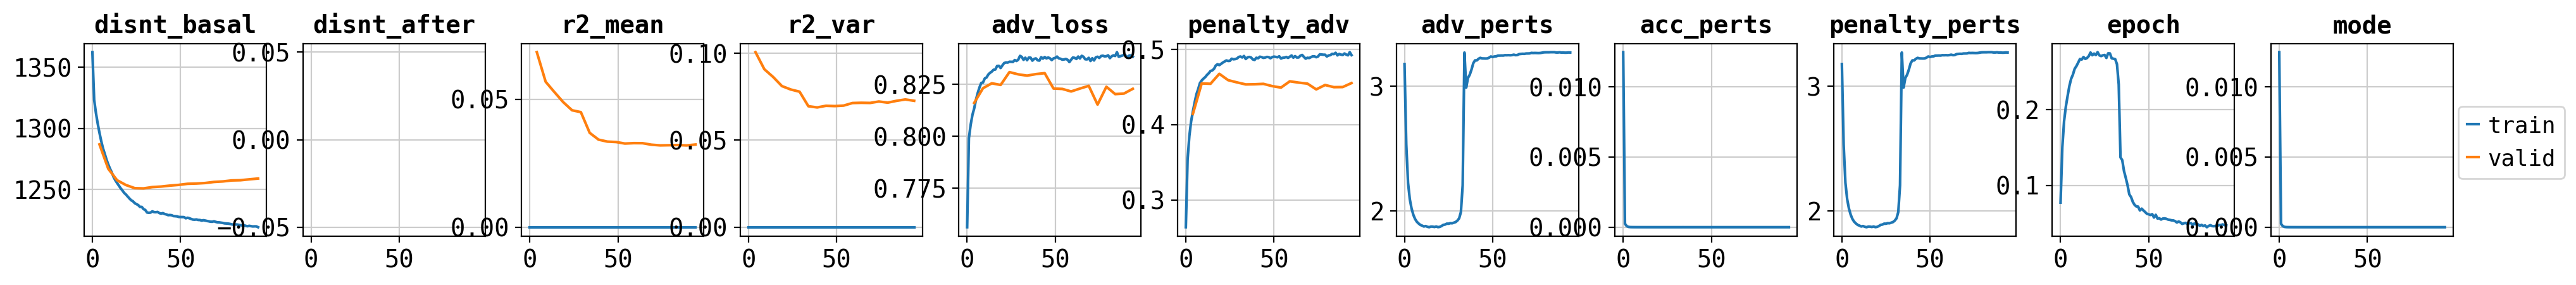

In [13]:
cpa.pl.plot_history(model)

If you already trained CPA, you can restore model weights by running the following cell:

In [9]:
model = cpa.CPA.load(dir_path='/home/mohsen/projects/cpa/lightning_logs/combo/', 
                     adata=adata, use_gpu=True)

INFO     File /home/mohsen/projects/cpa/lightning_logs/combo/model.pt already downloaded                           


100%|██████████| 32/32 [00:00<00:00, 1221.06it/s]
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Global seed set to 434


## Latent space UMAP visualization

Here, we visualize the latent representations of all cells. We computed basal and final latent representations with `model.get_latent_representation` function. 

In [10]:
latent_outputs = model.get_latent_representation(adata, batch_size=1024)

100%|██████████| 62/62 [00:03<00:00, 16.44it/s]


In [13]:
sc.settings.verbosity = 3

In [11]:
latent_basal_adata = latent_outputs['latent_basal']
latent_adata = latent_outputs['latent_after']

In [12]:
sc.pp.neighbors(latent_basal_adata)
sc.tl.umap(latent_basal_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [13]:
latent_basal_adata

AnnData object with n_obs × n_vars = 63378 × 128
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway1', 'pathway2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'condition', 'condition_ID', 'control', 'cell_type', 'smiles_rdkit', 'source', 'sample', 'Size_Factor', 'n.umi', 'RT_well', 'Drug1', 'Drug2', 'Well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'split', 'condition_old', 'pert_type', 'batch', 'split_1ct_MEC', 'split_2ct_MEC', 'split_3ct_MEC', 'batch_cov', 'batch_cov_cond', 'log_dose', 'cov_drug_dose', 'CPA_cat', 'CPA_CHEMBL504', '_scvi_condition_ID', '_scvi_cell_type', '_scvi_CPA_cat'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

The basal representation should be free of the variation(s) of the `'condition_ID' as observed below 

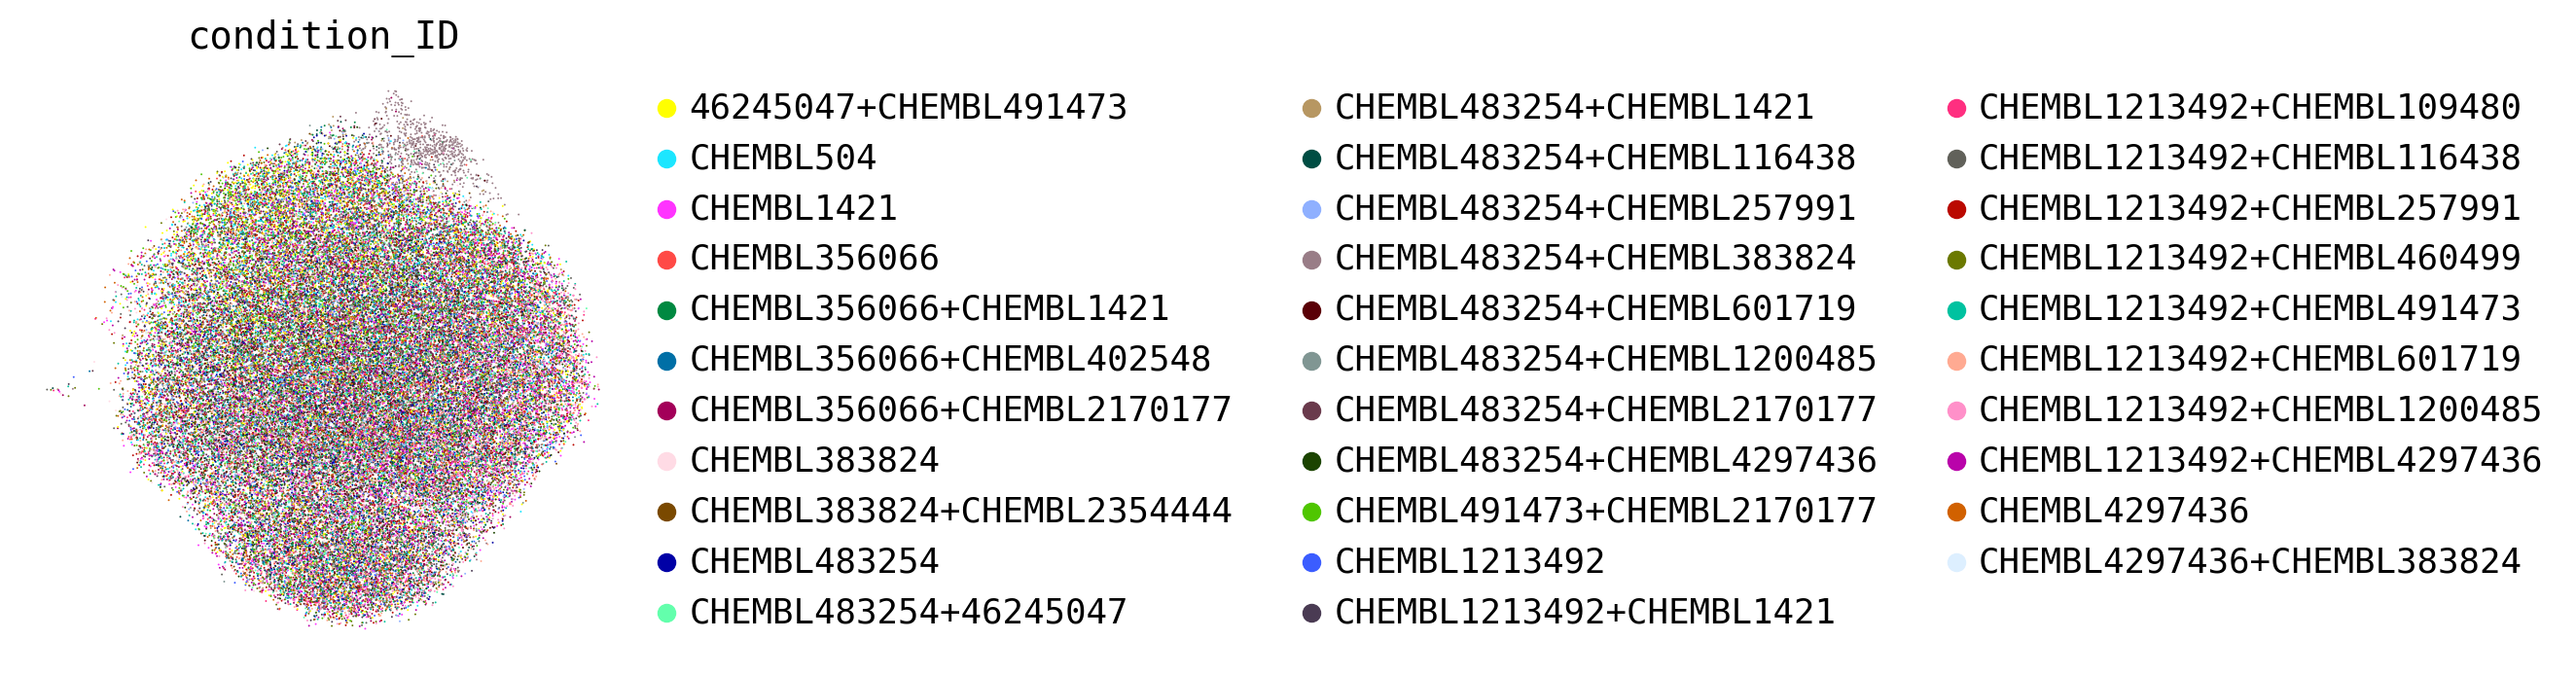

In [14]:
sc.pl.umap(latent_basal_adata, color=['condition_ID'], frameon=False, wspace=0.2)

Here, you can visualize that when the drug embedding is added to the basal representation, the cells treated with different drugs will be separated.

In [15]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


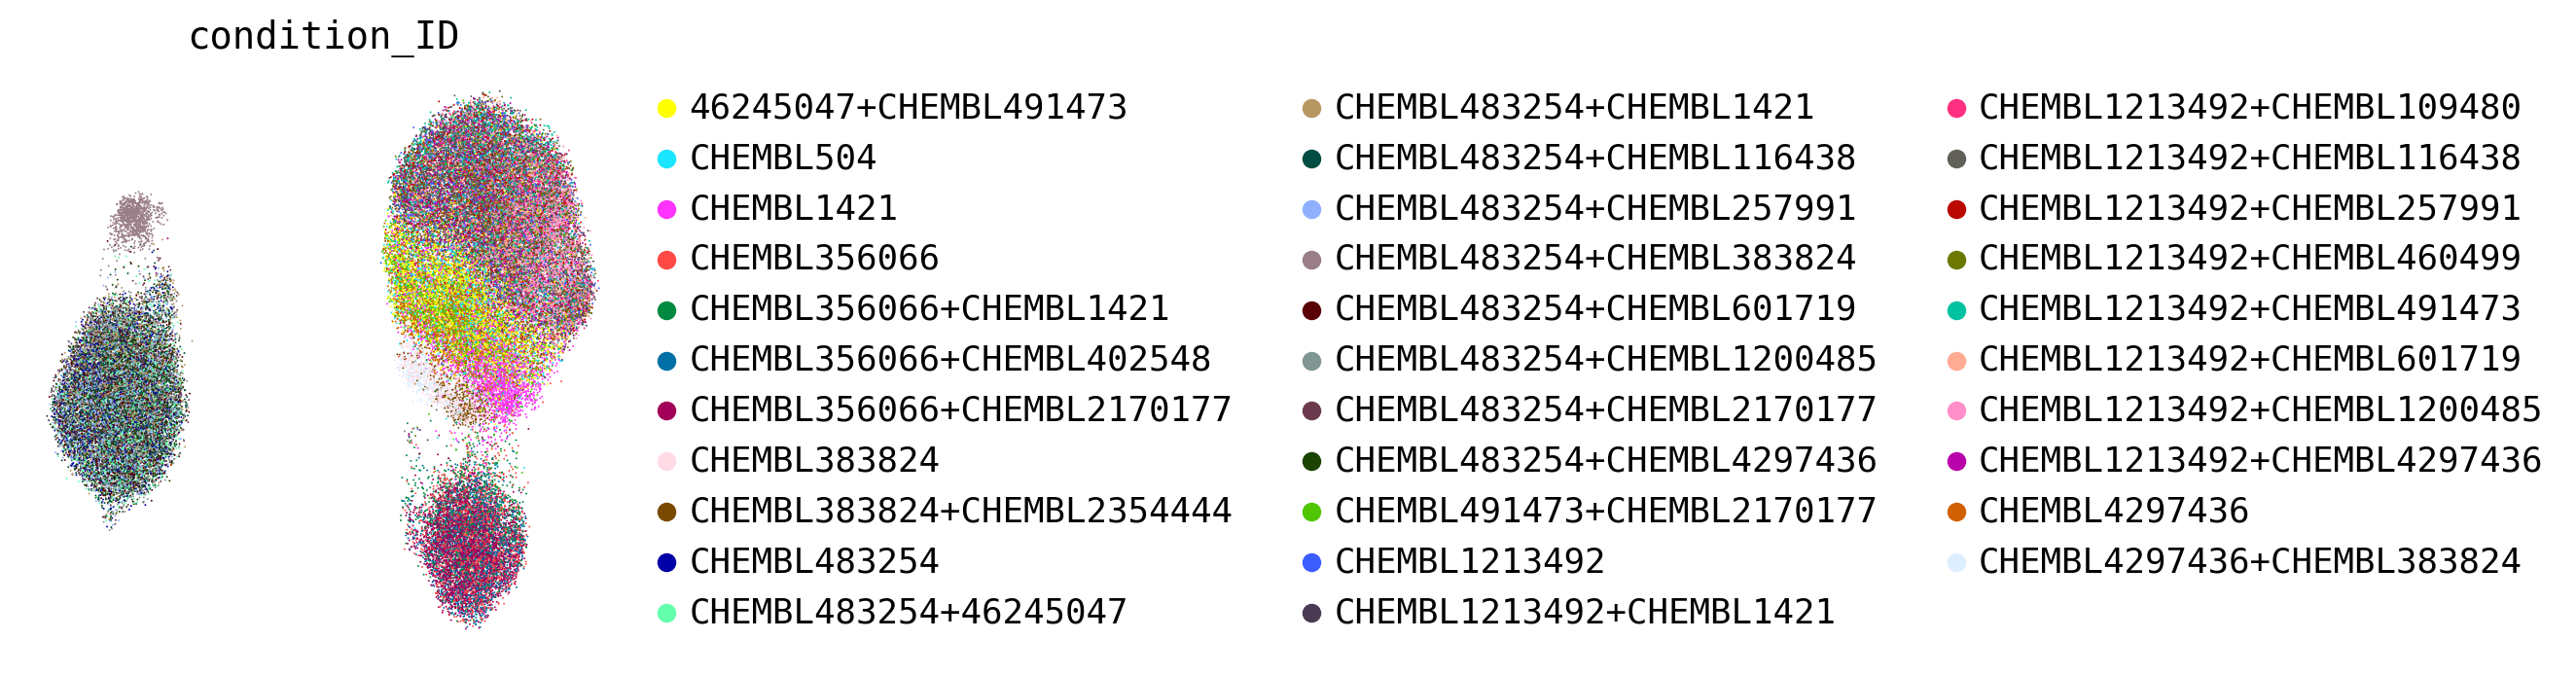

In [16]:
sc.pl.umap(latent_adata, color=['condition_ID'], frameon=False, wspace=0.2)

## Evaluation 

Next, we will evaluate the model's prediction performance on the whole dataset, including OOD (test) cells. The model will report metrics on how well we have
captured the variation in top `n` differentially expressed genes when compared to control cells
(DMSO, [CHEMBL 504](https://www.ebi.ac.uk/chembl/compound_report_card/CHEMBL504/))  for each condition. The metrics calculate the mean accuracy (`r2_mean_deg`), the variance (`r2_var_deg`) and similar metrics (`r2_mean_lfc_deg` and `log fold change`)to measure the log fold change of the predicted cells vs control`((LFC(control, ground truth) ~ LFC(control, predicted cells))`.  The `R2` is the `sklearn.metrics.r2_score` from [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html).

In [20]:
model.predict(adata, batch_size=1024)

100%|██████████| 62/62 [00:08<00:00,  7.55it/s]


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from collections import defaultdict
from tqdm import tqdm

n_top_degs = [10, 20, 50, None] # None means all genes

results = defaultdict(list)
ctrl_adata = adata[adata.obs['condition_ID'] == 'CHEMBL504'].copy()
for cat in tqdm(adata.obs['cov_drug_dose'].unique()):
    if 'CHEMBL504' not in cat:
        cat_adata = adata[adata.obs['cov_drug_dose'] == cat].copy()

        deg_cat = f'{cat}'
        deg_list = adata.uns['rank_genes_groups_cov'][deg_cat]
        
        x_true = cat_adata.layers['counts'].toarray()
        x_pred = cat_adata.obsm['CPA_pred']
        x_ctrl = ctrl_adata.layers['counts'].toarray()

        x_true = np.log1p(x_true)
        x_pred = np.log1p(x_pred)
        x_ctrl = np.log1p(x_ctrl)

        for n_top_deg in n_top_degs:
            if n_top_deg is not None:
                degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
            else:
                degs = np.arange(adata.n_vars)
                n_top_deg = 'all'
                
            x_true_deg = x_true[:, degs]
            x_pred_deg = x_pred[:, degs]
            x_ctrl_deg = x_ctrl[:, degs]
            
            r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
            r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))

            r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_deg.mean(0), x_pred_deg.mean(0) - x_ctrl_deg.mean(0))
            r2_var_lfc_deg = r2_score(x_true_deg.var(0) - x_ctrl_deg.var(0), x_pred_deg.var(0) - x_ctrl_deg.var(0))

            cov, cond, dose = cat.split('_')
            
            results['cell_type'].append(cov)
            results['condition'].append(cond)
            results['dose'].append(dose)
            results['n_top_deg'].append(n_top_deg)
            results['r2_mean_deg'].append(r2_mean_deg)
            results['r2_var_deg'].append(r2_var_deg)
            results['r2_mean_lfc_deg'].append(r2_mean_lfc_deg)
            results['r2_var_lfc_deg'].append(r2_var_lfc_deg)

df = pd.DataFrame(results)

100%|██████████| 32/32 [00:15<00:00,  2.10it/s]


In [22]:
df[df['n_top_deg'] == 20]

cell_type                    condition     dose n_top_deg  r2_mean_deg  \
1        A549                 CHEMBL483254      3.0        20     0.967421   
5        A549   CHEMBL491473+CHEMBL2170177  3.0+3.0        20     0.962717   
9        A549   CHEMBL1213492+CHEMBL257991  3.0+3.0        20     0.869307   
13       A549        CHEMBL483254+46245047  3.0+3.0        20     0.970208   
17       A549   CHEMBL483254+CHEMBL2170177  3.0+3.0        20     0.968506   
21       A549                 CHEMBL356066      3.0        20     0.935541   
25       A549   CHEMBL356066+CHEMBL2170177  3.0+3.0        20     0.947310   
29       A549   CHEMBL483254+CHEMBL1200485  3.0+3.0        20     0.969701   
33       A549   CHEMBL1213492+CHEMBL491473  3.0+3.0        20     0.641915   
37       A549                CHEMBL1213492      3.0        20     0.895580   
41       A549    CHEMBL356066+CHEMBL402548  3.0+3.0        20     0.852191   
45       A549      CHEMBL483254+CHEMBL1421  3.0+3.0        20     0.957488   
49       A549   CHEMBL1213492+CHEMBL109480  3.0+3.0        20     0.818061   
53       A549   CHEMBL1213492+CHEMBL460499  3.0+3.0        20     0.899389   
57       A549   CHEMBL483254+CHEMBL4297436  3.0+3.0        20     0.919735   
61       A549    CHEMBL483254+CHEMBL257991  3.0+3.0        20     0.956477   
65       A549    CHEMBL483254+CHEMBL601719  3.0+3.0        20     0.964190   
69       A549   CHEMBL383824+CHEMBL2354444  3.0+3.0        20     0.956984   
73       A549  CHEMBL1213492+CHEMBL4297436  3.0+3.0        20     0.895441   
77       A549  CHEMBL1213492+CHEMBL1200485  3.0+3.0        20     0.941326   
81       A549    CHEMBL483254+CHEMBL383824  3.0+3.0        20     0.756303   
85       A549                 CHEMBL383824      3.0        20     0.908421   
89       A549    CHEMBL483254+CHEMBL116438  3.0+3.0        20     0.971904   
93       A549     CHEMBL1213492+CHEMBL1421  3.0+3.0        20     0.902487   
97       A549   CHEMBL4297436+CHEMBL383824  3.0+3.0        20     0.740274   
101      A549      CHEMBL356066+CHEMBL1421  3.0+3.0        20     0.929562   
105      A549                CHEMBL4297436      3.0        20     0.796419   
109      A549   CHEMBL1213492+CHEMBL116438  3.0+3.0        20     0.919315   
113      A549   CHEMBL1213492+CHEMBL601719  3.0+3.0        20     0.839387   
117      A549        46245047+CHEMBL491473  3.0+3.0        20     0.883893   
121      A549                   CHEMBL1421      3.0        20     0.950044   

     r2_var_deg  r2_mean_lfc_deg  r2_var_lfc_deg  
1      0.379410         0.991763        0.807461  
5     -0.623639         0.475555      -18.077933  
9     -2.036985         0.509137       -4.899390  
13     0.456921         0.991650        0.813883  
17     0.261224         0.990237        0.713178  
21     0.174922         0.978043        0.749956  
25     0.335508         0.983684        0.805031  
29     0.390255         0.990890        0.765023  
33    -1.228658         0.514041       -3.090287  
37    -2.776267         0.699633       -1.395146  
41    -0.223018         0.954963        0.675036  
45     0.265722         0.988489        0.744195  
49    -0.812865         0.921359       -1.243313  
53    -2.703637         0.767022       -3.808961  
57     0.375467         0.976873        0.779405  
61     0.274221         0.987838        0.750310  
65     0.293376         0.988411        0.725715  
69    -0.765112         0.971313        0.258857  
73    -0.618630         0.691770       -0.443078  
77     0.245628         0.971003        0.768830  
81    -0.656045         0.920463        0.393564  
85    -1.523500         0.874507       -0.707571  
89     0.506375         0.992483        0.840598  
93    -2.819458         0.864271       -2.265155  
97    -0.753398         0.830227        0.074761  
101    0.274883         0.982519        0.785440  
105   -3.606721        -0.526552      -14.992378  
109   -2.284597         0.721021       -4.020803  
113   -0.597107         0.80

`n_top_deg` shows how many DEGs genes were used to calculate the metric. 

We can further visualize these per condition

A549_CHEMBL483254_3.0 (1578, 5000)
Top 20 DEGs var:  0.9674240647799511
All genes var:  0.30564831092038325


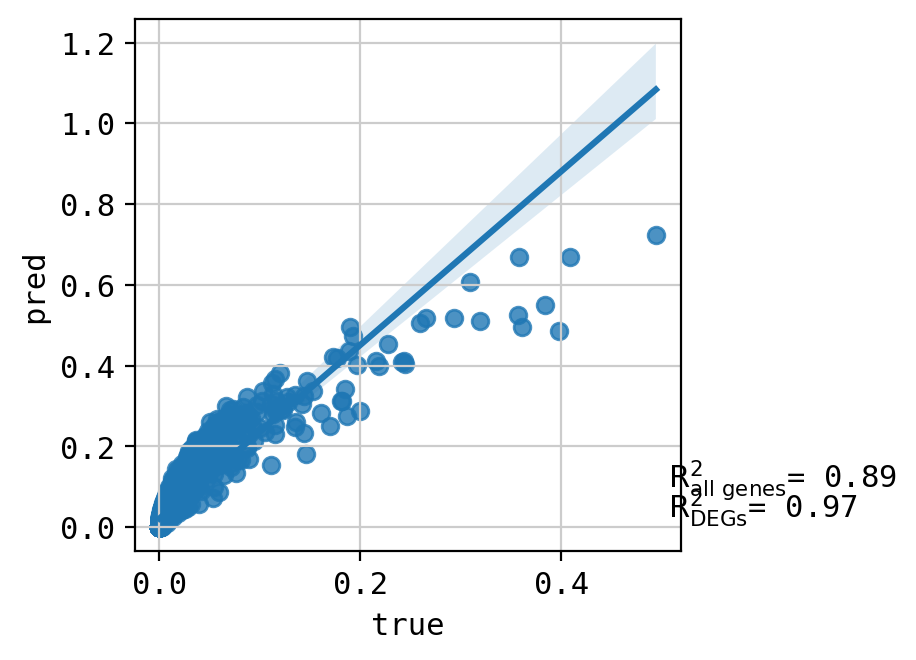

A549_CHEMBL491473+CHEMBL2170177_3.0+3.0 (2161, 5000)
Top 20 DEGs var:  0.9627187921391631
All genes var:  0.3677191966657336


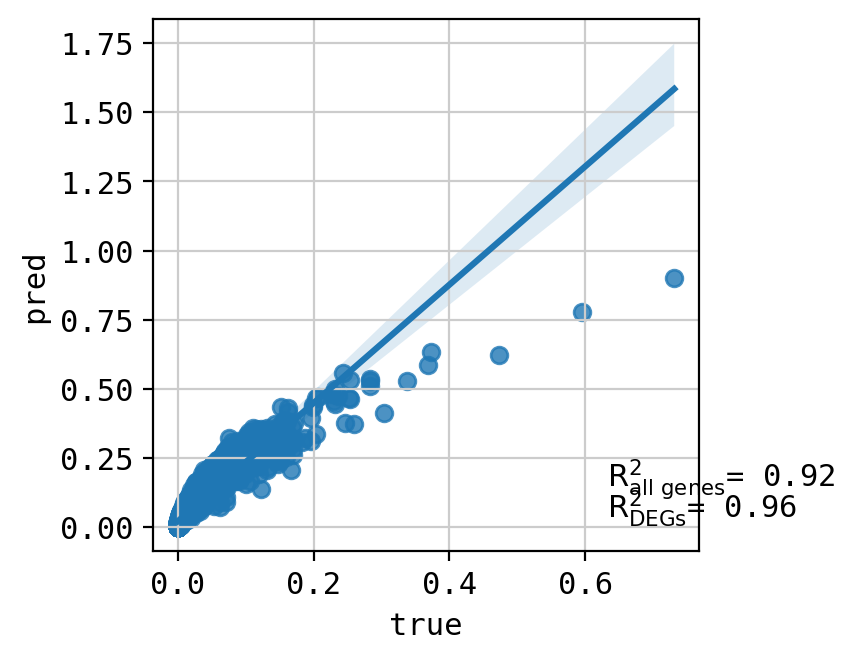

A549_CHEMBL1213492+CHEMBL257991_3.0+3.0 (2260, 5000)
Top 20 DEGs var:  0.8693143108409295
All genes var:  0.32830499840643523


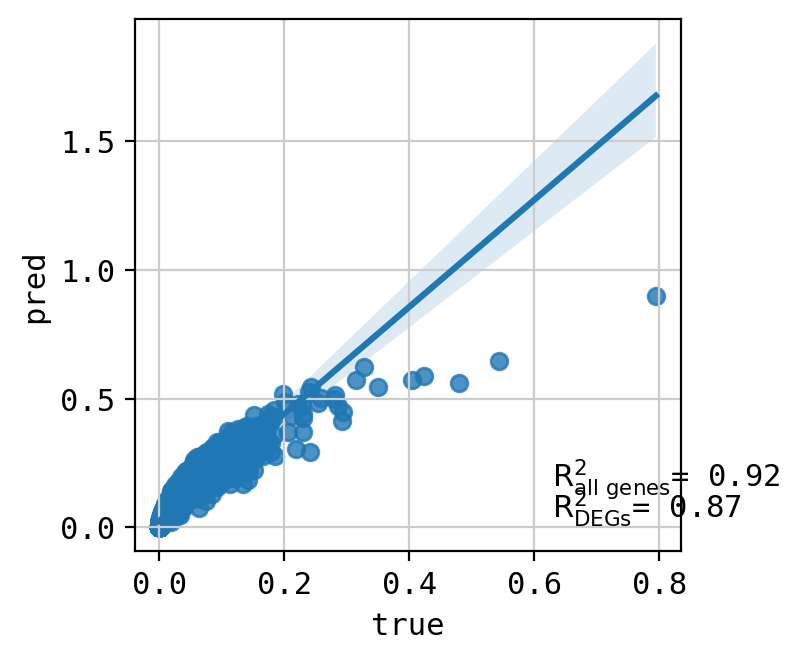

A549_CHEMBL483254+46245047_3.0+3.0 (1889, 5000)
Top 20 DEGs var:  0.970209673172722
All genes var:  0.42205899370560873


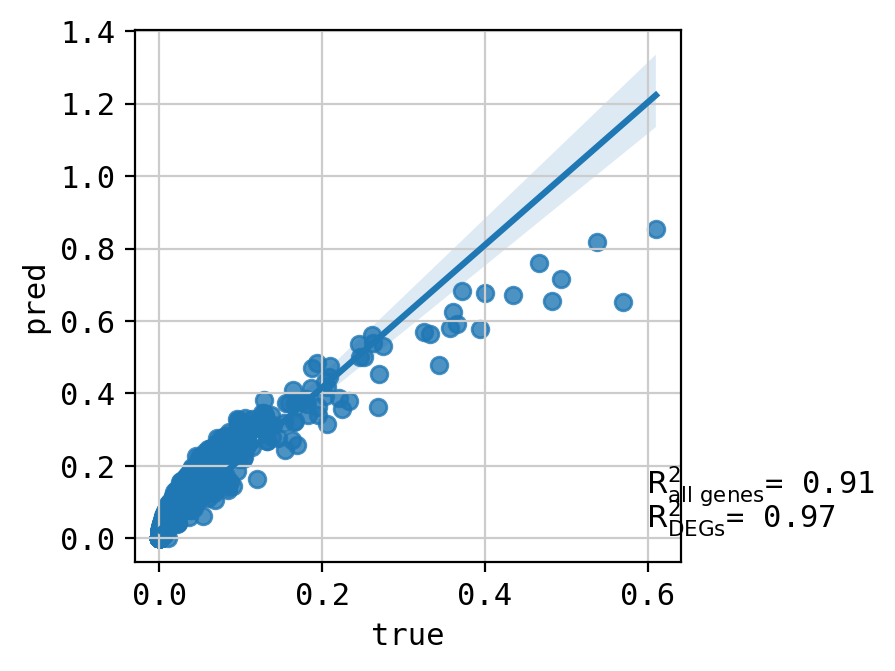

A549_CHEMBL483254+CHEMBL2170177_3.0+3.0 (1814, 5000)
Top 20 DEGs var:  0.968507309155123
All genes var:  0.34981293176885053


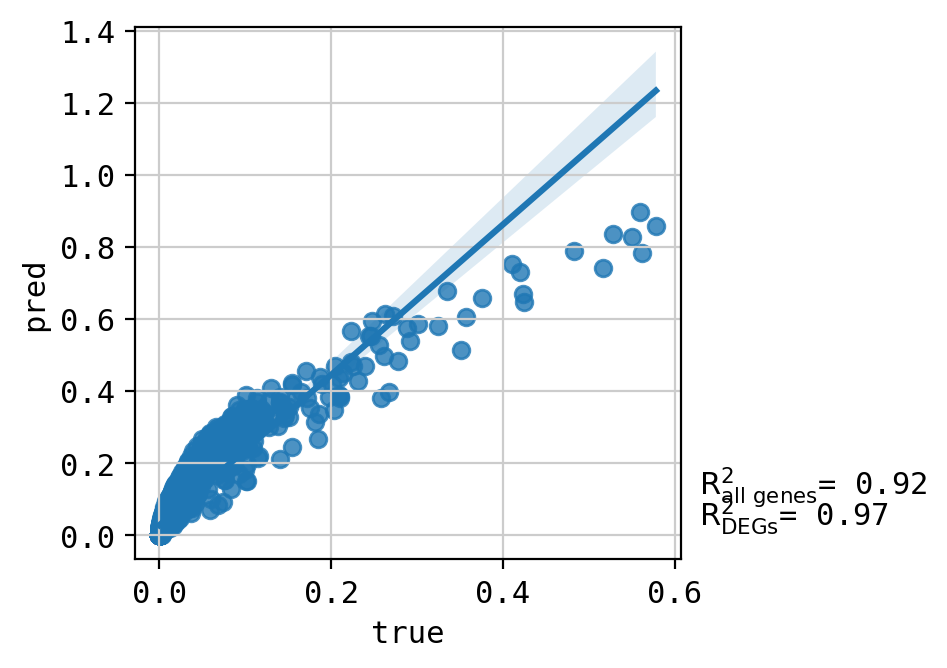

A549_CHEMBL356066_3.0 (1869, 5000)
Top 20 DEGs var:  0.9355440682391789
All genes var:  0.2884194789856178


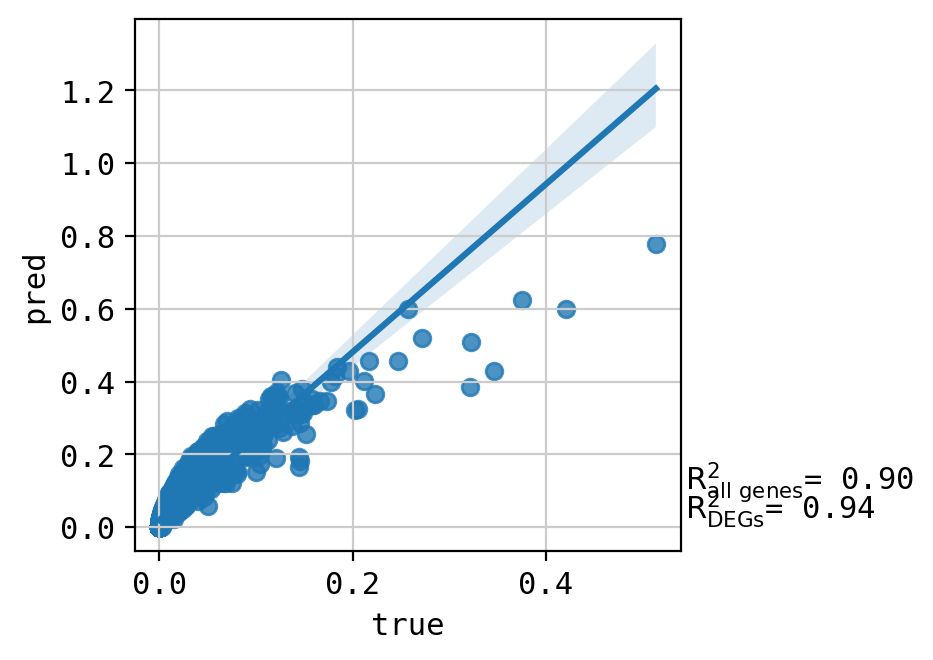

A549_CHEMBL356066+CHEMBL2170177_3.0+3.0 (3298, 5000)
Top 20 DEGs var:  0.947310703191107
All genes var:  0.29835334467419505


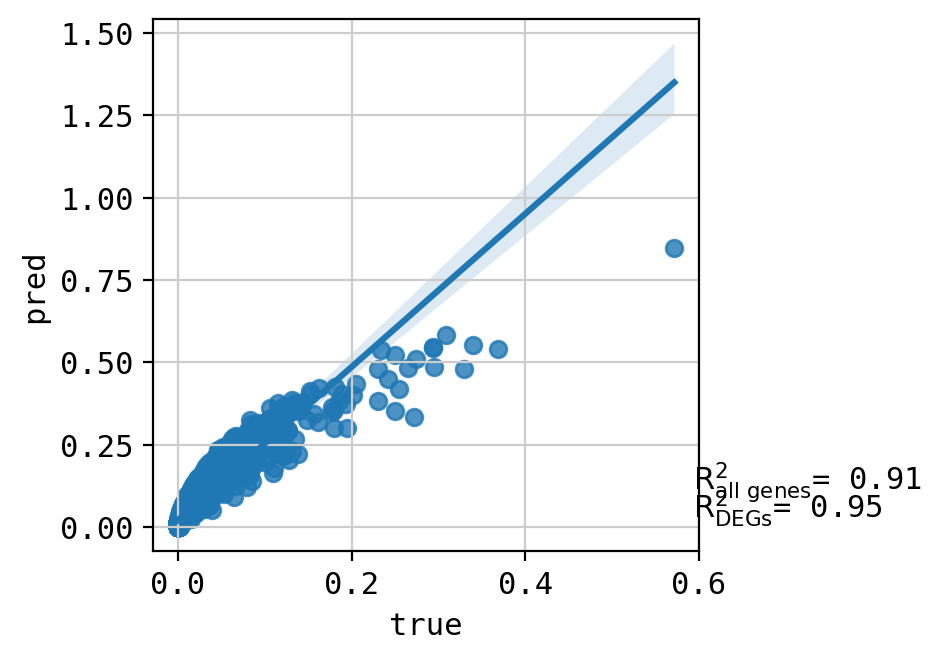

A549_CHEMBL483254+CHEMBL1200485_3.0+3.0 (2013, 5000)
Top 20 DEGs var:  0.969701753626122
All genes var:  0.3981900429521762


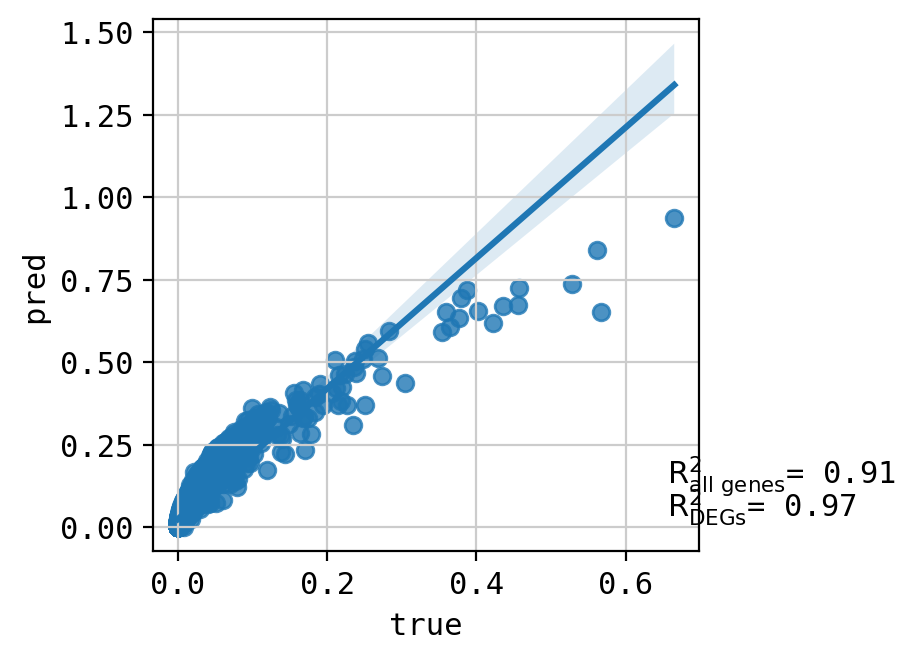

A549_CHEMBL1213492+CHEMBL491473_3.0+3.0 (2783, 5000)
Top 20 DEGs var:  0.6419152626745332
All genes var:  0.2886166540493904


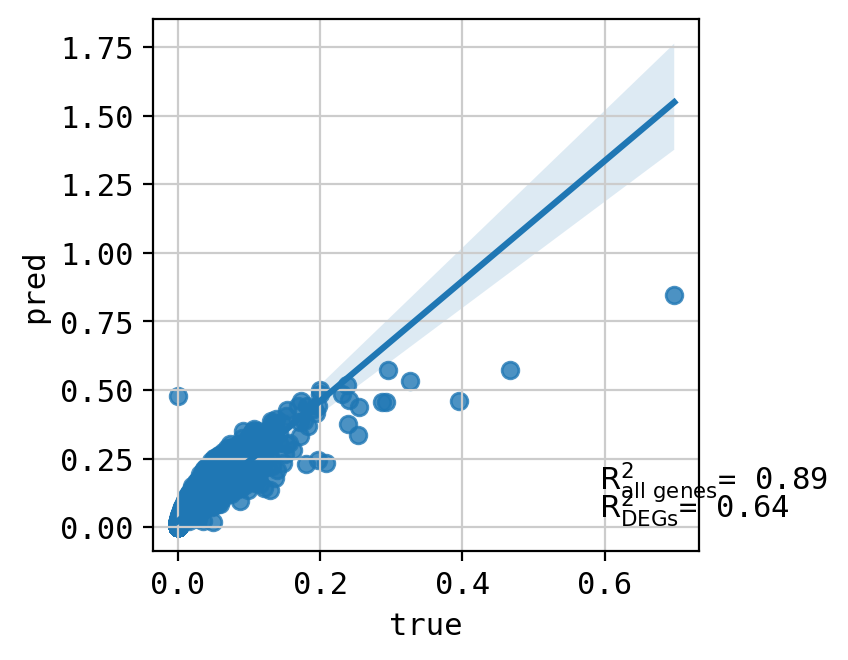

A549_CHEMBL1213492_3.0 (1682, 5000)
Top 20 DEGs var:  0.895586478486223
All genes var:  0.297598943550916


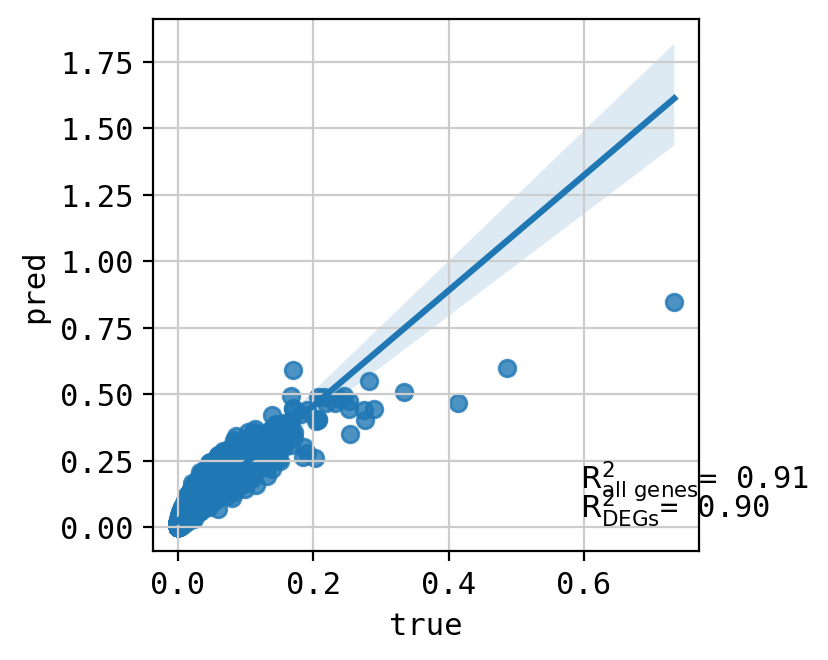

A549_CHEMBL356066+CHEMBL402548_3.0+3.0 (1939, 5000)
Top 20 DEGs var:  0.8521916098477549
All genes var:  0.17711482339864315


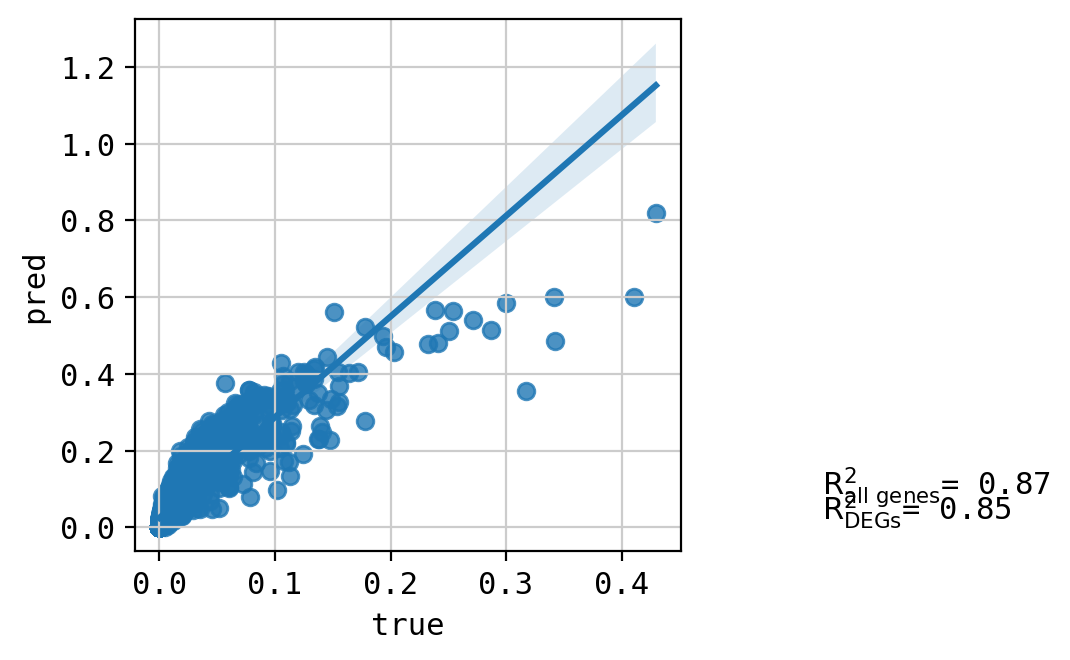

A549_CHEMBL483254+CHEMBL1421_3.0+3.0 (1955, 5000)
Top 20 DEGs var:  0.9574904467120635
All genes var:  0.306132009112956


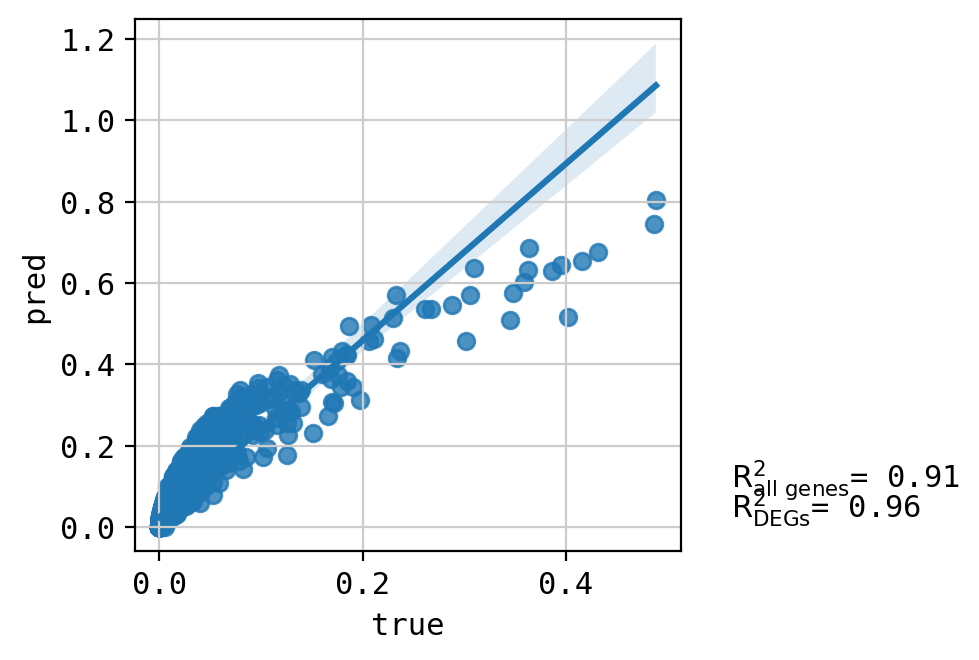

A549_CHEMBL1213492+CHEMBL109480_3.0+3.0 (1310, 5000)
Top 20 DEGs var:  0.8180723568291253
All genes var:  0.3774129061389593


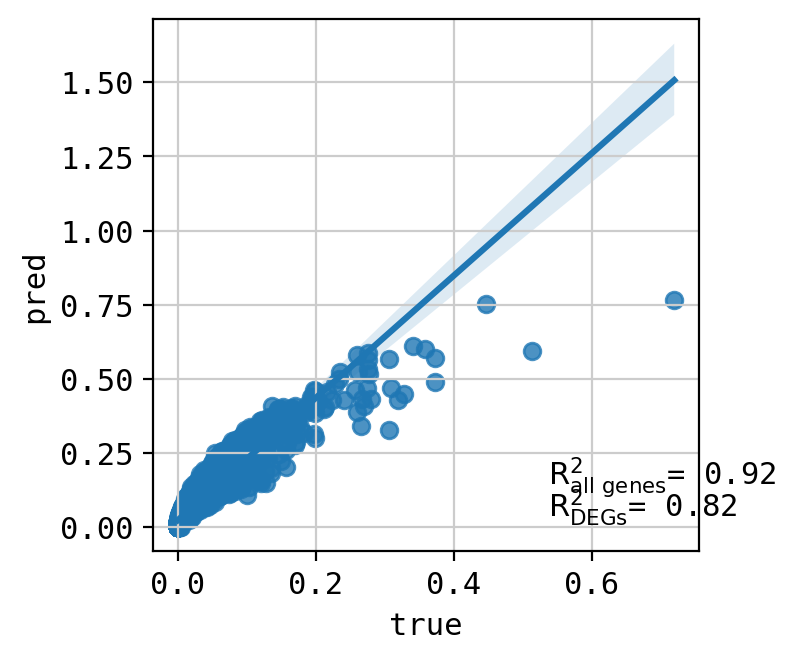

A549_CHEMBL1213492+CHEMBL460499_3.0+3.0 (2692, 5000)
Top 20 DEGs var:  0.8993912250910164
All genes var:  0.2901722828562925


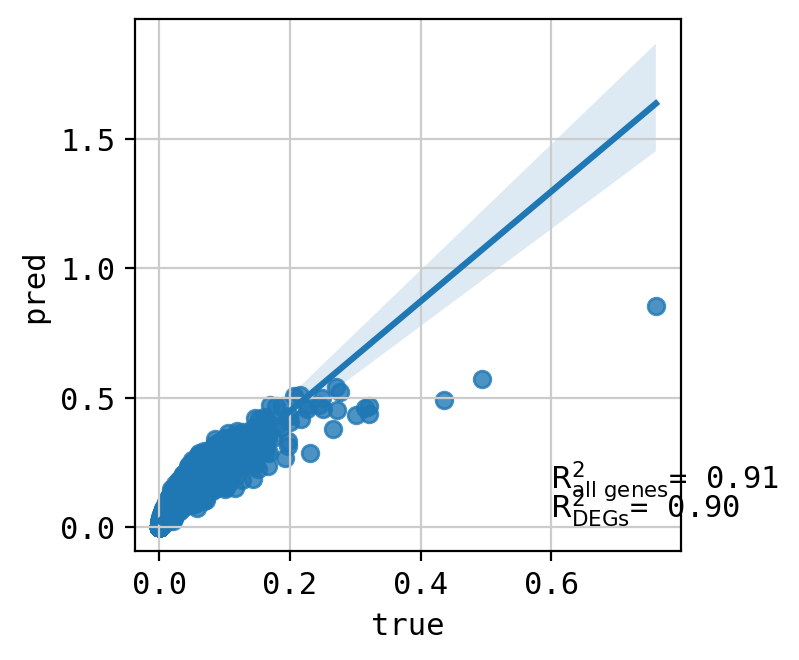

A549_CHEMBL483254+CHEMBL4297436_3.0+3.0 (1971, 5000)
Top 20 DEGs var:  0.9197375227935931
All genes var:  0.296415384031939


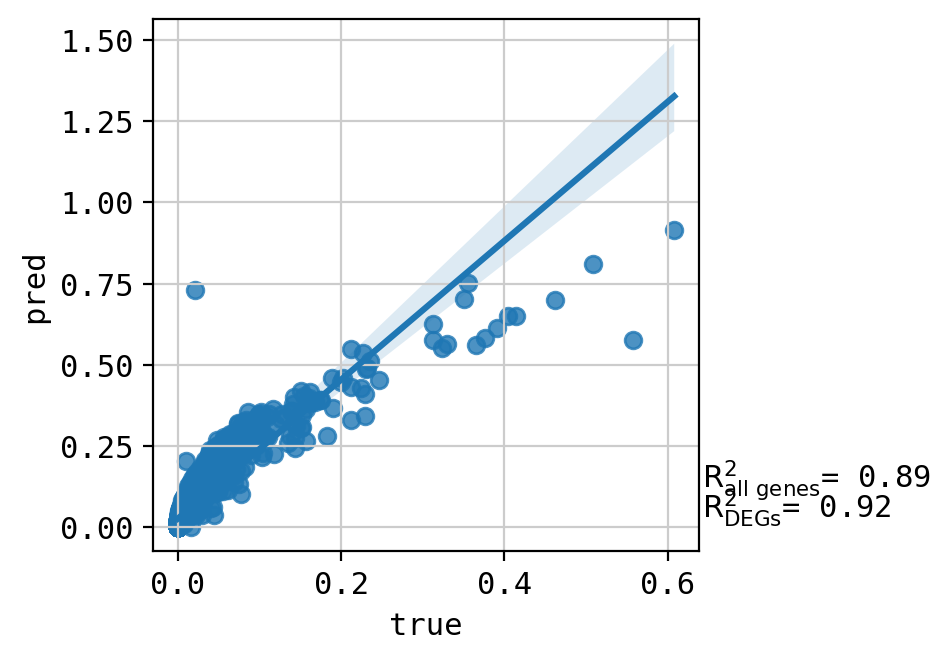

A549_CHEMBL483254+CHEMBL257991_3.0+3.0 (1826, 5000)
Top 20 DEGs var:  0.9564792218882475
All genes var:  0.3108349920170532


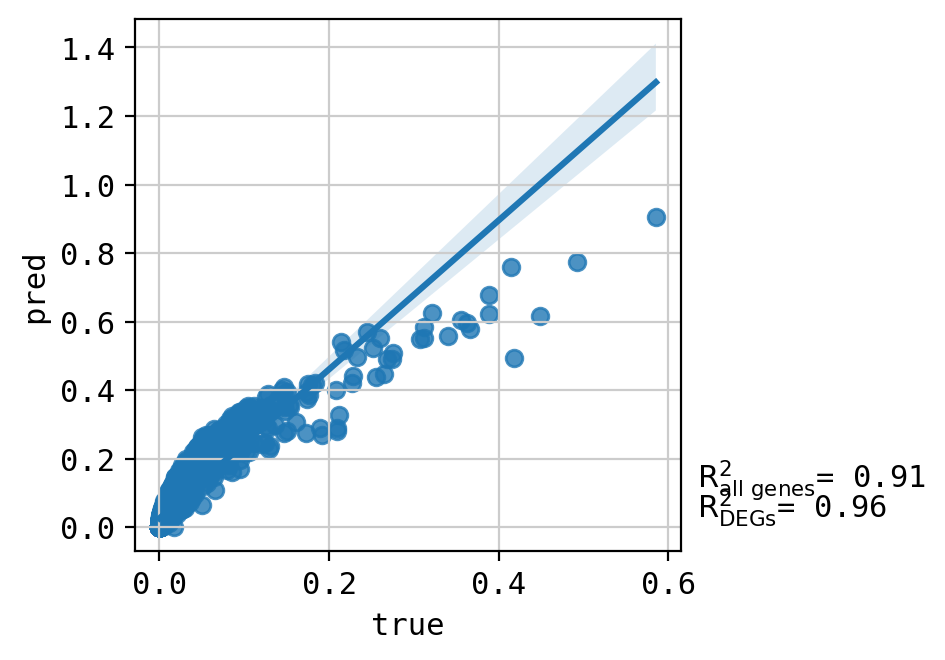

A549_CHEMBL483254+CHEMBL601719_3.0+3.0 (1641, 5000)
Top 20 DEGs var:  0.9641929190351832
All genes var:  0.355529304962353


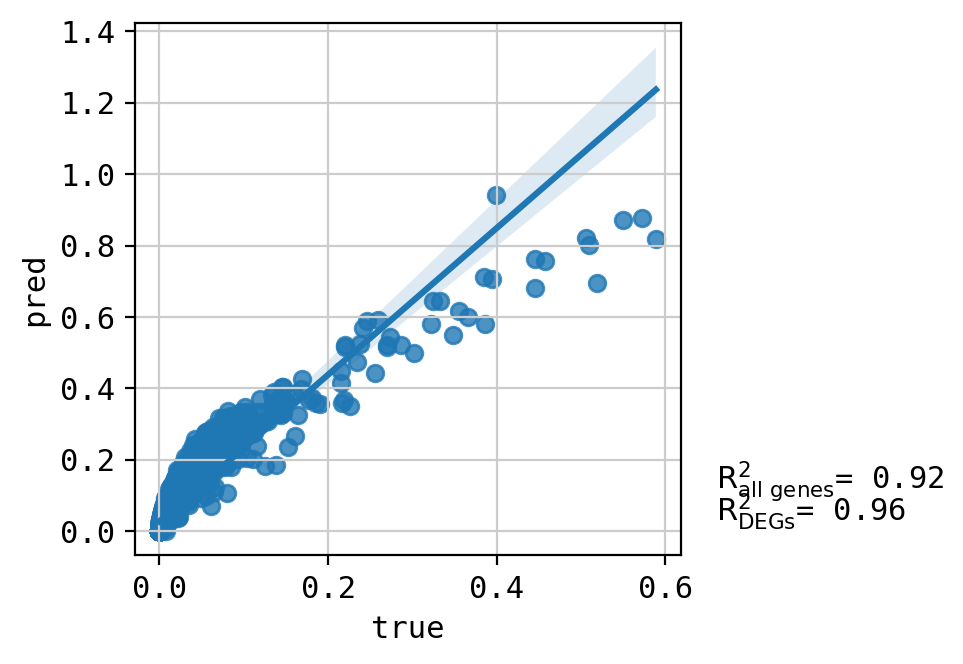

A549_CHEMBL383824+CHEMBL2354444_3.0+3.0 (476, 5000)
Top 20 DEGs var:  0.9569839749219734
All genes var:  0.392374583026051


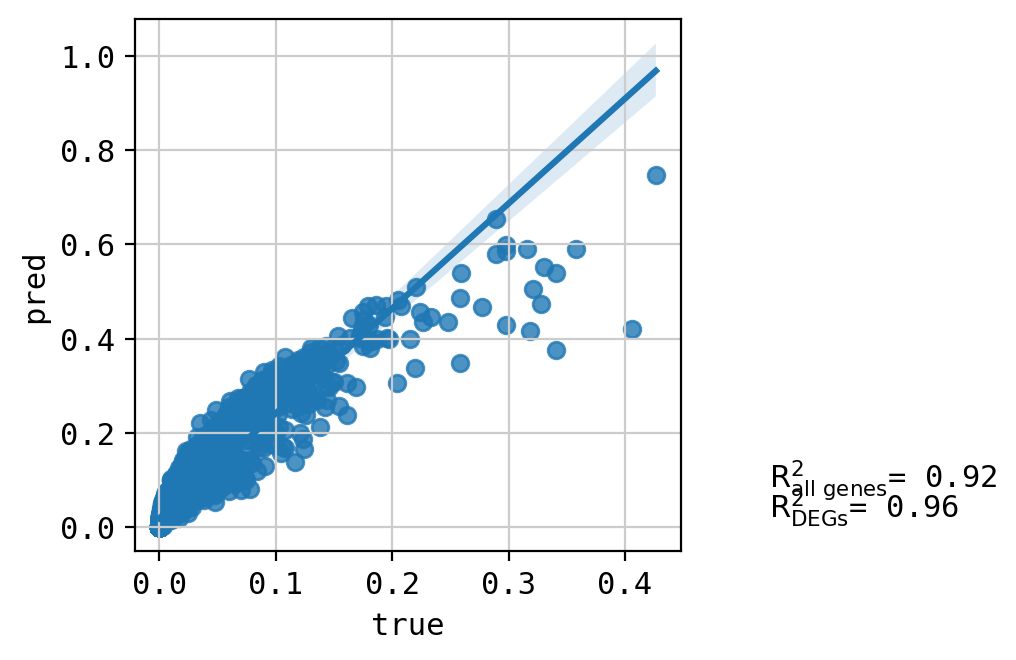

A549_CHEMBL1213492+CHEMBL4297436_3.0+3.0 (2353, 5000)
Top 20 DEGs var:  0.8954470865997979
All genes var:  0.3615505179215007


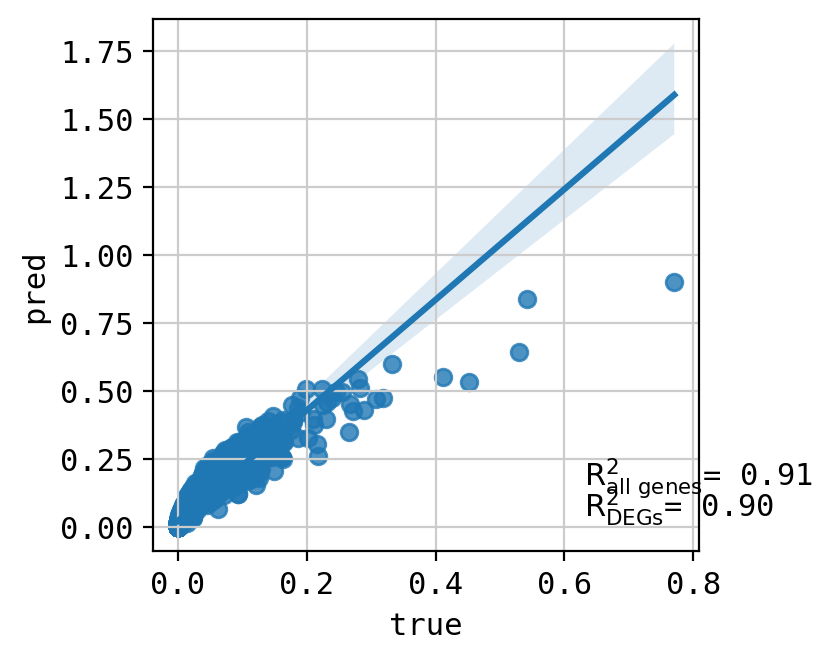

A549_CHEMBL1213492+CHEMBL1200485_3.0+3.0 (2734, 5000)
Top 20 DEGs var:  0.9413281346007902
All genes var:  0.23785497259112265


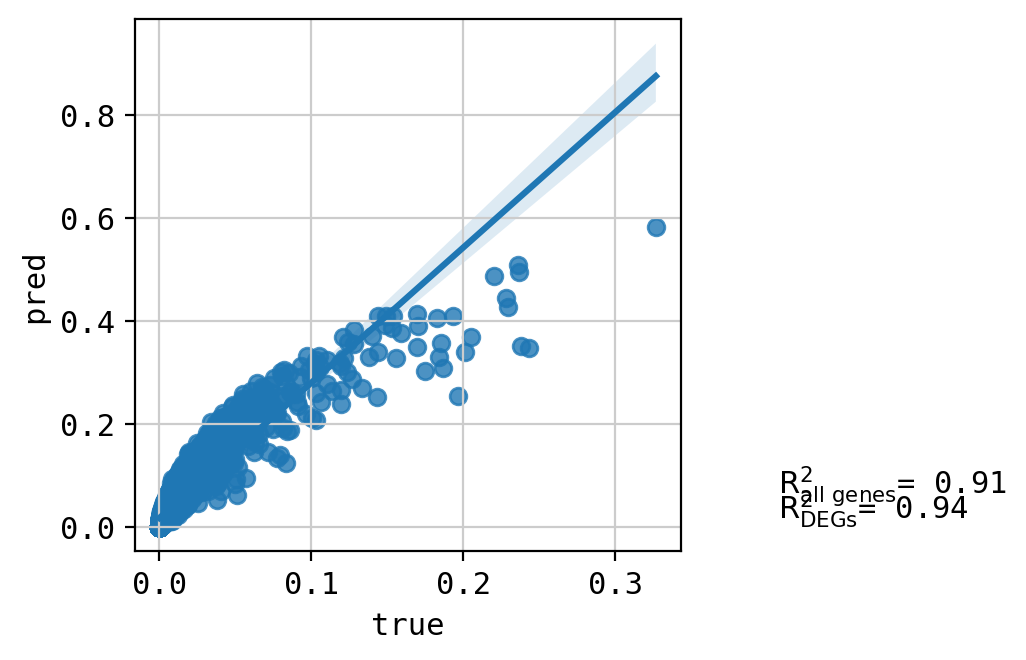

A549_CHEMBL483254+CHEMBL383824_3.0+3.0 (996, 5000)
Top 20 DEGs var:  0.7562991246339705
All genes var:  0.26840814857775785


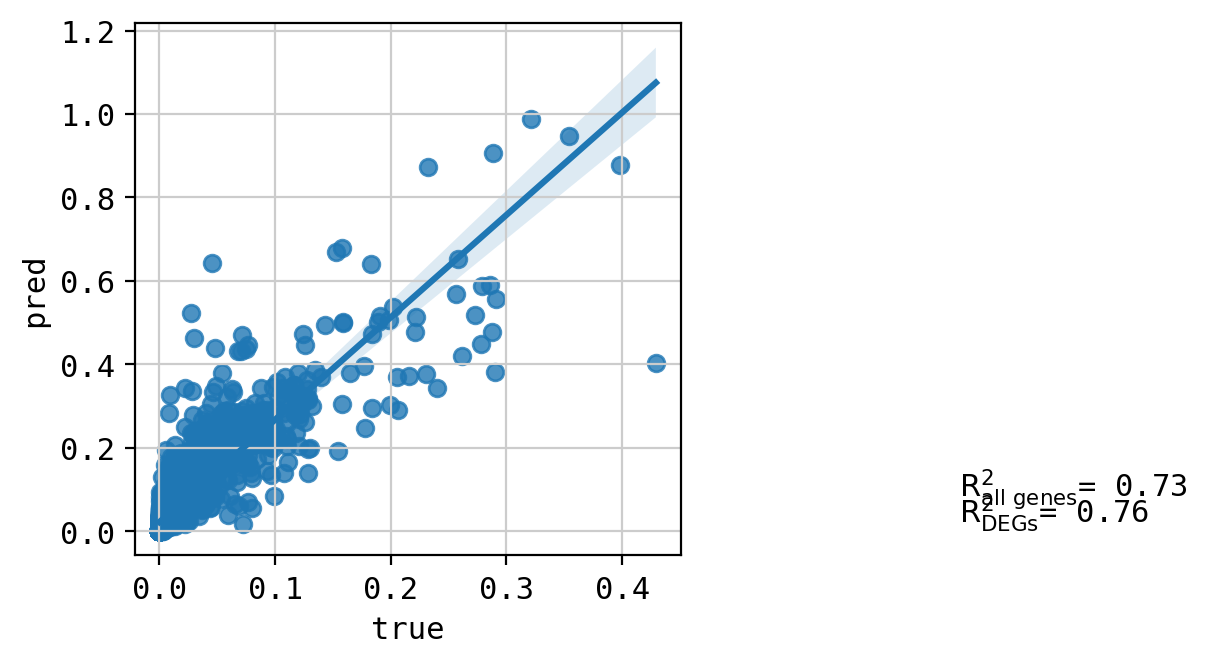

A549_CHEMBL383824_3.0 (758, 5000)
Top 20 DEGs var:  0.9084240268321863
All genes var:  0.4196952752284211


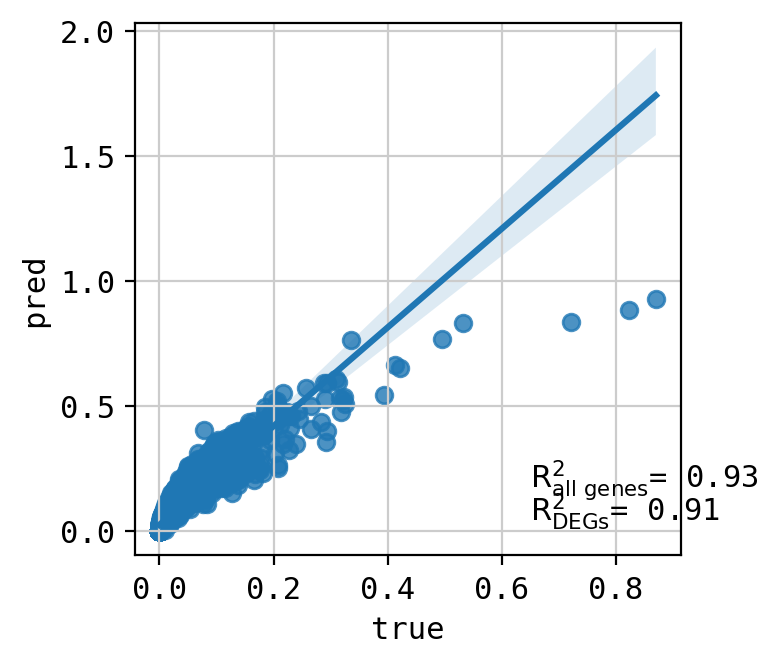

A549_CHEMBL483254+CHEMBL116438_3.0+3.0 (2244, 5000)
Top 20 DEGs var:  0.9719052298160451
All genes var:  0.34125343107376216


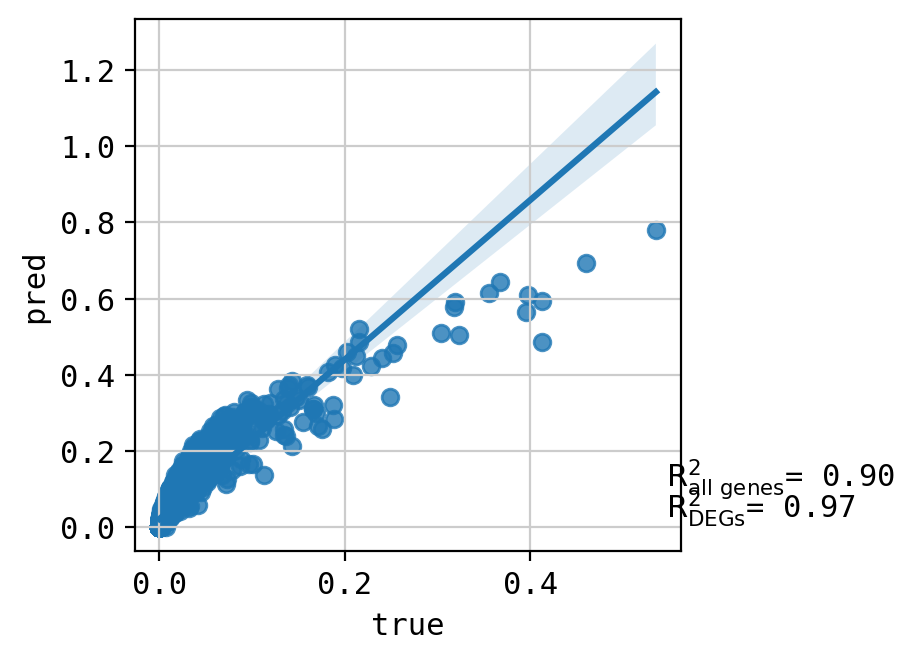

A549_CHEMBL1213492+CHEMBL1421_3.0+3.0 (2421, 5000)
Top 20 DEGs var:  0.9024922269486448
All genes var:  0.3315774060432729


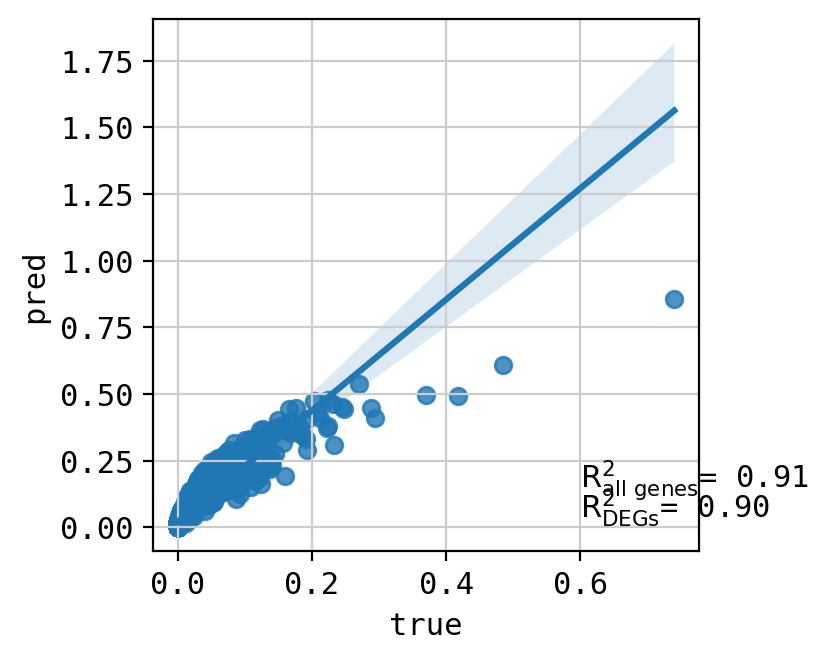

A549_CHEMBL4297436+CHEMBL383824_3.0+3.0 (520, 5000)
Top 20 DEGs var:  0.7402719446227342
All genes var:  0.3035742524646492


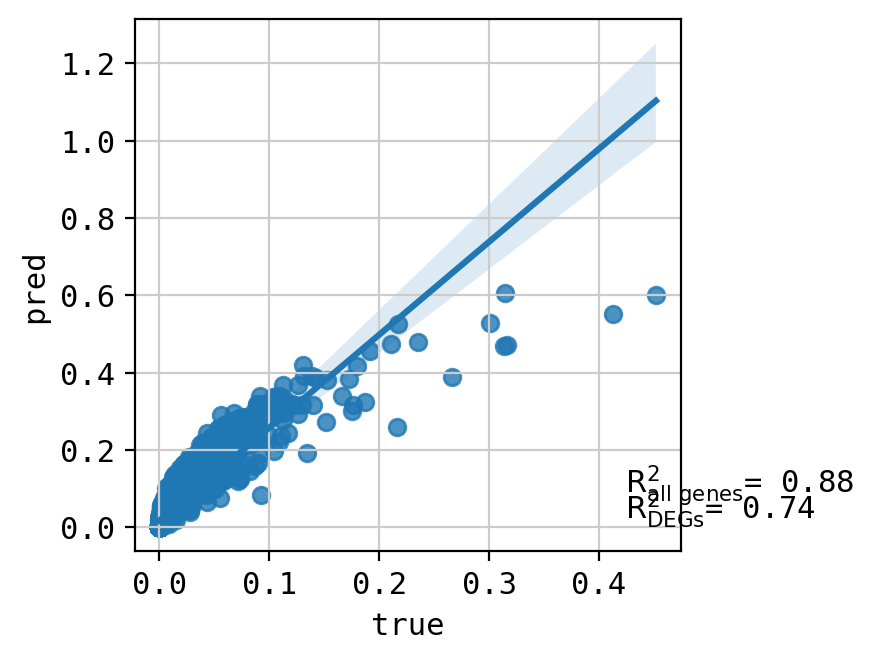

A549_CHEMBL356066+CHEMBL1421_3.0+3.0 (1231, 5000)
Top 20 DEGs var:  0.9295645803594607
All genes var:  0.27320817319690516


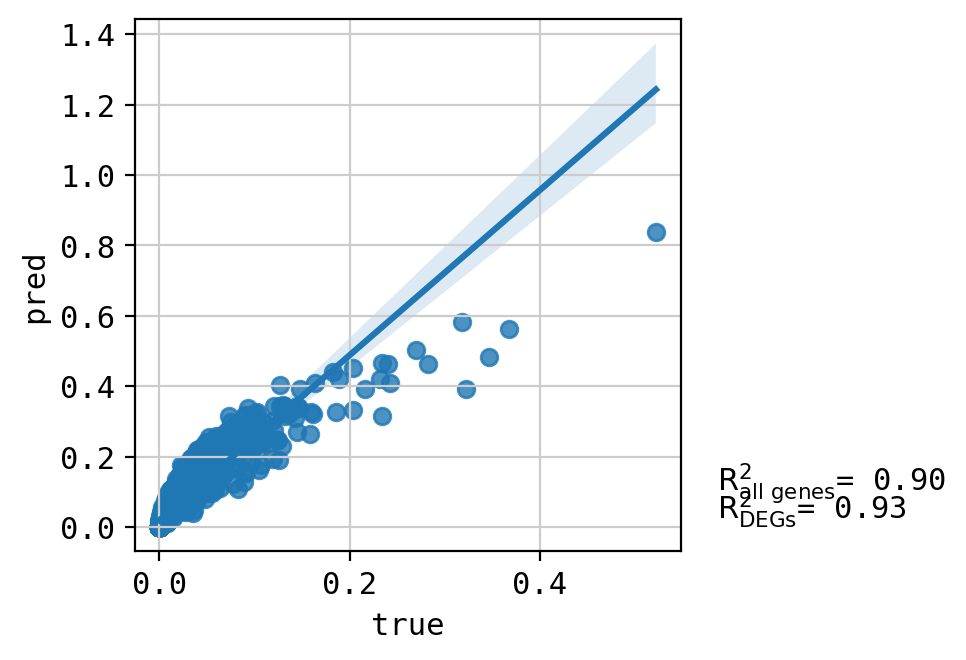

A549_CHEMBL4297436_3.0 (2756, 5000)
Top 20 DEGs var:  0.796438607517489
All genes var:  0.3385659832204526


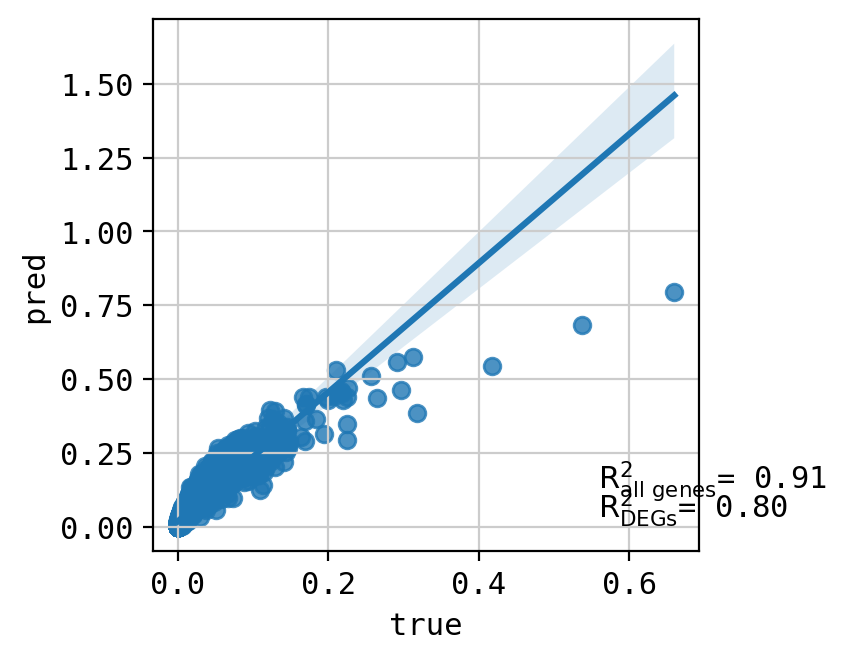

A549_CHEMBL1213492+CHEMBL116438_3.0+3.0 (2736, 5000)
Top 20 DEGs var:  0.9193170101193121
All genes var:  0.3456261304848878


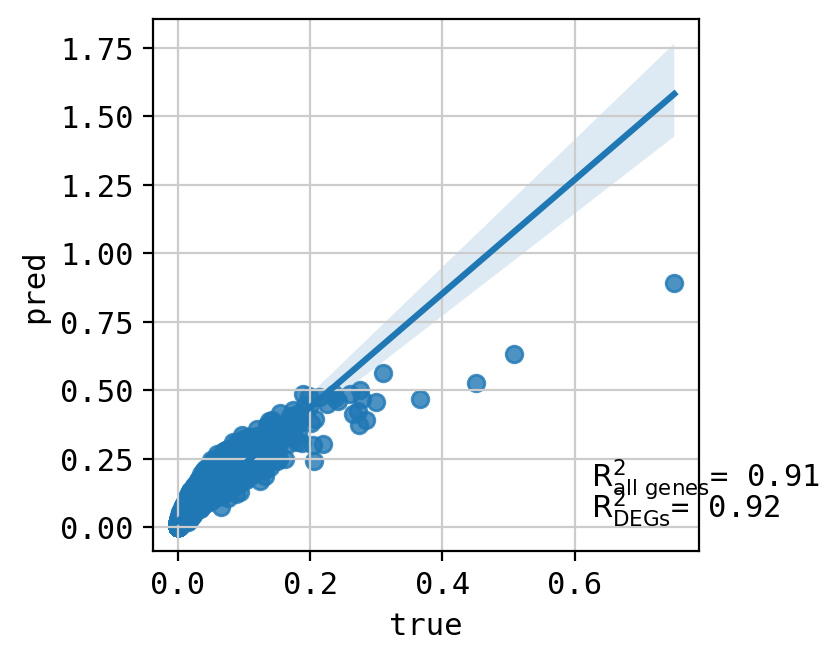

A549_CHEMBL1213492+CHEMBL601719_3.0+3.0 (2662, 5000)
Top 20 DEGs var:  0.8393930793862192
All genes var:  0.31913373394294486


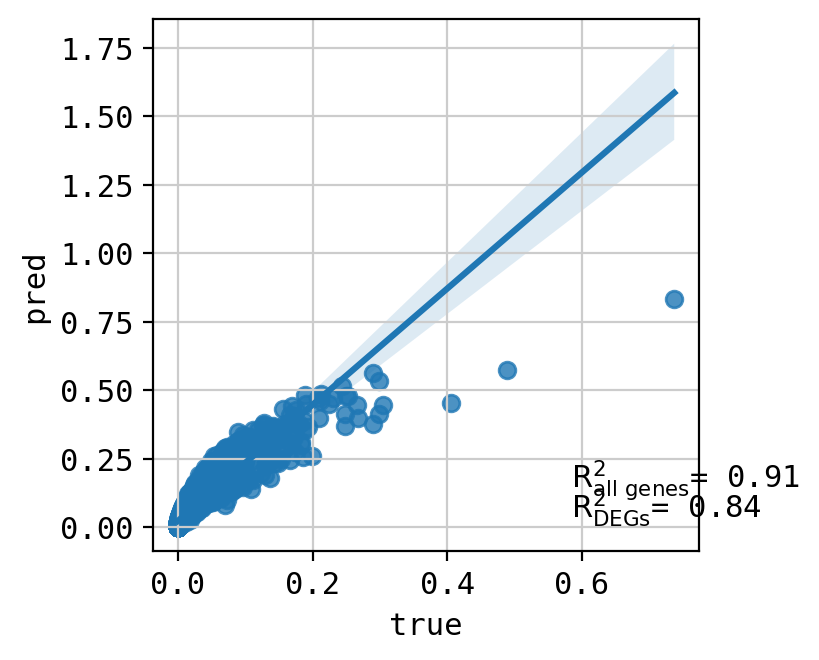

A549_46245047+CHEMBL491473_3.0+3.0 (3016, 5000)
Top 20 DEGs var:  0.8838971303802778
All genes var:  0.34256699909884714


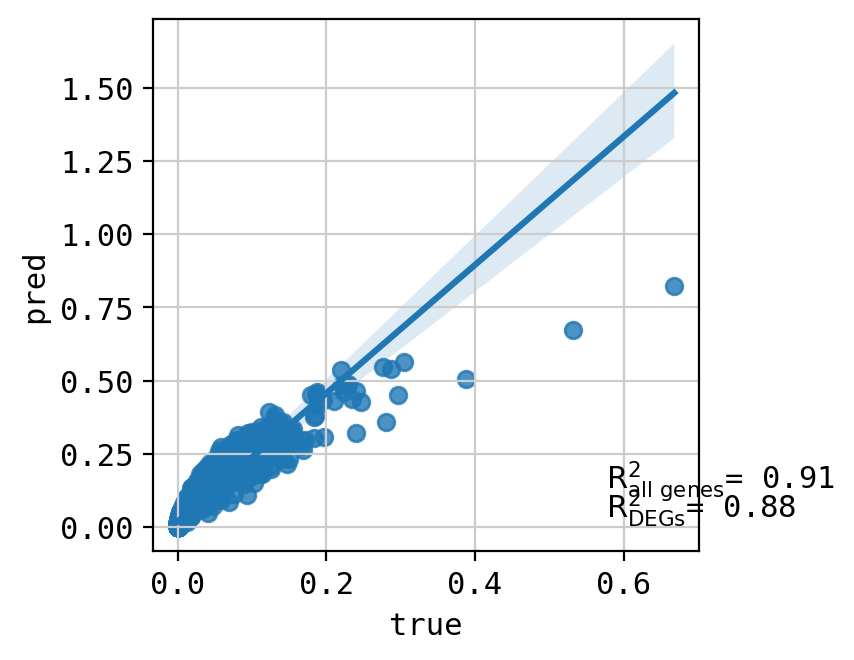

A549_CHEMBL1421_3.0 (2343, 5000)
Top 20 DEGs var:  0.9500464229368459
All genes var:  0.2601272896605


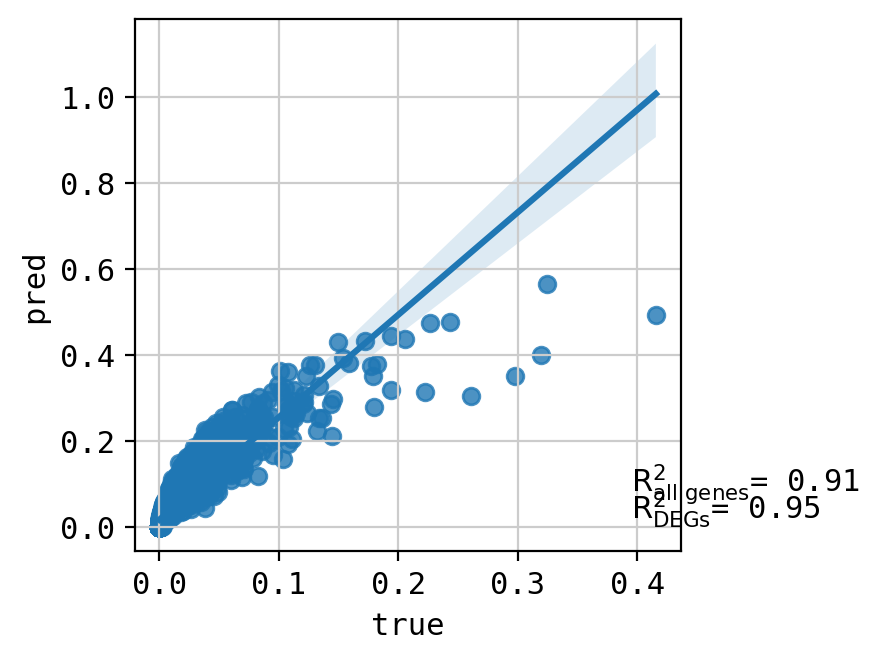

In [21]:
for cat in adata.obs["cov_drug_dose"].unique():
    if "CHEMBL504" not in cat:
        cat_adata = adata[adata.obs["cov_drug_dose"] == cat].copy()

        cat_adata.X = np.log1p(cat_adata.layers["counts"].A)
        cat_adata.obsm["CPA_pred"] = np.log1p(cat_adata.obsm["CPA_pred"])

        deg_list = adata.uns["rank_genes_groups_cov"][f'{cat}'][:20]

        print(cat, f"{cat_adata.shape}")
        cpa.pl.mean_plot(
            cat_adata,
            pred_obsm_key="CPA_pred",
            path_to_save=None,
            deg_list=deg_list,
            # gene_list=deg_list[:5],
            show=True,
            verbose=True,
        )

## Visualizing similarity between drug embeddings

CPA learns an embedding for each covariate, and those can visualised to compare the similarity between perturbation (i.e. which perturbation have similar gene expression responses) 

In [15]:
cpa_api = cpa.ComPertAPI(adata, model, 
                         de_genes_uns_key='rank_genes_groups_cov', 
                         pert_category_key='cov_drug_dose',
                         control_group='CHEMBL504',
                         )

In [18]:
cpa_plots = cpa.pl.CompertVisuals(cpa_api, fileprefix=None)

In [16]:
cpa_api.num_measured_points['train']

{'A549_46245047+CHEMBL491473_3.0+3.0': 2723,
 'A549_CHEMBL1213492+CHEMBL109480_3.0+3.0': 1175,
 'A549_CHEMBL1213492+CHEMBL116438_3.0+3.0': 2447,
 'A549_CHEMBL1213492+CHEMBL1200485_3.0+3.0': 2479,
 'A549_CHEMBL1213492+CHEMBL1421_3.0+3.0': 2158,
 'A549_CHEMBL1213492+CHEMBL257991_3.0+3.0': 2037,
 'A549_CHEMBL1213492+CHEMBL4297436_3.0+3.0': 2127,
 'A549_CHEMBL1213492+CHEMBL460499_3.0+3.0': 2425,
 'A549_CHEMBL1213492+CHEMBL601719_3.0+3.0': 2383,
 'A549_CHEMBL1213492_3.0': 1527,
 'A549_CHEMBL1421_3.0': 2133,
 'A549_CHEMBL356066+CHEMBL1421_3.0+3.0': 1124,
 'A549_CHEMBL356066+CHEMBL2170177_3.0+3.0': 2975,
 'A549_CHEMBL356066_3.0': 1679,
 'A549_CHEMBL383824+CHEMBL2354444_3.0+3.0': 421,
 'A549_CHEMBL383824_3.0': 690,
 'A549_CHEMBL4297436_3.0': 2491,
 'A549_CHEMBL483254+46245047_3.0+3.0': 1697,
 'A549_CHEMBL483254+CHEMBL116438_3.0+3.0': 2016,
 'A549_CHEMBL483254+CHEMBL1200485_3.0+3.0': 1810,
 'A549_CHEMBL483254+CHEMBL1421_3.0+3.0': 1762,
 'A549_CHEMBL483254+CHEMBL2170177_3.0+3.0': 1629,
 'A549_CH

In [17]:
drug_adata = cpa_api.get_pert_embeddings()
drug_adata.shape

(19, 128)

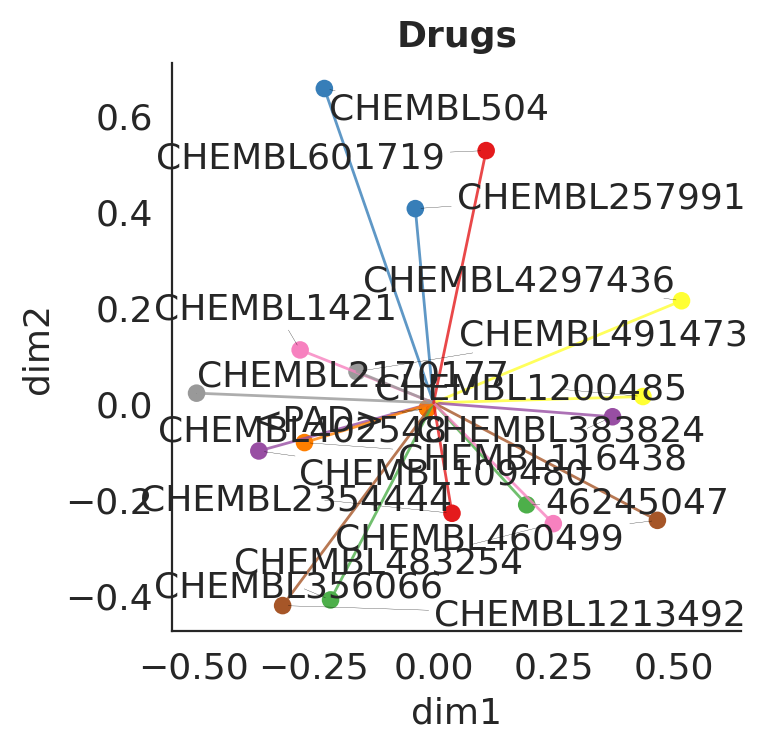

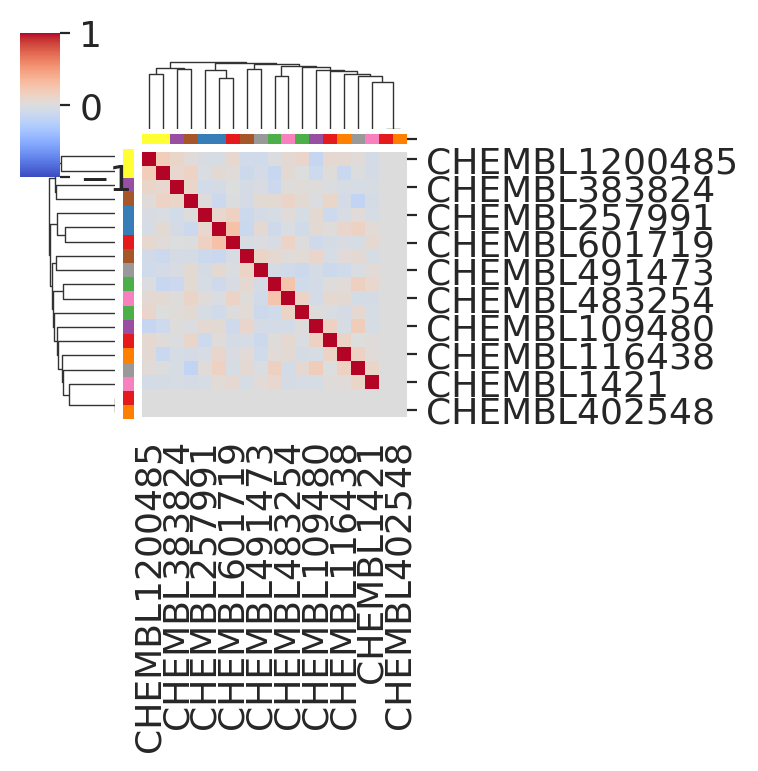

In [19]:
cpa_plots.plot_latent_embeddings(drug_adata.X, kind='perturbations', titlename='Drugs')